In [5]:
import torch

torch.random.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [110]:
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
import os
import pandas as pd
import copy



def discrete_color(color_stroke, allowed_colors, just_inds=False): #(n*5, 3)
    ''' color_stroke in RGB
    allowed_colors in BGR '''
    allowed_colors_tensors = [np.array([allowed_colors[i]] * color_stroke.shape[0]) for i in range(len(allowed_colors))]
    
    l2_distances = np.zeros((color_stroke.shape[0], len(allowed_colors_tensors)))
    for i in range(len(allowed_colors_tensors)):
        l2_distances[:, i] = np.sum((color_stroke - allowed_colors_tensors[i])**2, axis=1)
        for j in range(l2_distances.shape[0]):
            color1_rgb = sRGBColor(color_stroke[j,0], color_stroke[j,1], color_stroke[j,2])
            color2_rgb = sRGBColor(allowed_colors[i][2], allowed_colors[i][1], allowed_colors[i][0])
            color1_lab = convert_color(color1_rgb, LabColor)
            color2_lab = convert_color(color2_rgb, LabColor)
            l2_distances[j, i] = delta_e_cie2000(color1_lab, color2_lab)

    color_inds = np.tile(np.argmin(l2_distances, axis=1)[np.newaxis].T,(1,3))
    if just_inds:
        return color_inds
    
    new_color_stroke = np.zeros(color_stroke.shape)
    for i in range(len(allowed_colors_tensors)):
        new_color_stroke = np.where(color_inds == i, allowed_colors_tensors[i], new_color_stroke)

    return new_color_stroke


def color_cluster(img, n_colors=10):
    """
    Cluster the colors of a given image
    
    args:
        img (np.array[width, height] : image in BGR
    kwargs:
        n_colors (int) : number of colors to cluster
        
    return:
        List((B,G,R),...) : List of BGR tuples
    """
    allowed_colors = []

    colors = img.reshape((img.shape[0]*img.shape[1]), 3) / 255.

    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(colors)

    for i in range(n_colors):
        c = kmeans.cluster_centers_[i] # c is in BGR format
        allowed_colors.append(c) #BGR format appended
    return allowed_colors # They're global anyways

def save_colors(allowed_colors, actions, output_dir):
    """
    Save the colors used as an image so you know how to mix the paints
    
    args:
        allowed_colors (List((B,G,R),...) : List of BGR tuples
        actions (List(actions)) : list of 13 valued tuples. Used to determine how much each color is used
        output_dir (String) : Where to save the image
    """
    n_colors = len(allowed_colors)
    fig, ax = plt.subplots(2, 6, figsize=(1*12, 5))
    i = 0 
    w = 128
    for c in allowed_colors:
        # print('[', int(255*c[2]), ', ', int(255*c[1]), ', ', int(255*c[0]), '],', end='', sep='')
        num_uses = np.sum(actions[:,12] == i)
        ax[i//6, i%6].imshow(np.concatenate((np.ones((w,w,1))*c[2], np.ones((w,w,1))*c[1], np.ones((w,w,1))*c[0]), axis=-1))
        ax[i//6, i%6].set_xticks([])
        ax[i//6, i%6].set_yticks([])
        ax[i//6, i%6].set_title(i)
        ax[i//6, i%6].set_xlabel(str(num_uses) + ' uses')
        i += 1
    while i < 12:
        ax[i//6, i%6].imshow(np.concatenate((np.ones((w,w,1)), np.ones((w,w,1)), np.ones((w,w,1))), axis=-1))
        ax[i//6, i%6].set_xticks([])
        ax[i//6, i%6].set_yticks([])
        ax[i//6, i%6].set_title('Not used')
        i += 1
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'colors.png'))

def group_strokes_by_color(strokes):
    ''' Sort the strokes by color '''
    strokes = sorted(copy.deepcopy(strokes),key=lambda l:l[12], reverse=False)
    return strokes

MAX_ITERATIONS = 100
def draw(f, width=128, height=128):
    """
    Draw a stroke onto a blank, 1-channel canvas
    
    args:
        f (Tuple) : x0, y0, x1, y1, x2, y2, z0, z2, w0, w2
        r (int) : radius in pixels of stroke
    
    kwargs:
        width (int) :  Width of canvas. (Default 128)
        height (int) :  Height of canvas. (Default 128)
    
    return:
        np.array[width, height] : matrix (boolean map) with the stroke drawn on it.
    """
    x0, y0, x1, y1, x2, y2, z0, z2, w0, w2 = f
    x0, y0, x1, y1, x2, y2 = x0*width, y0*height, x1*width, y1*height, x2*width, y2*height
    canvas = np.zeros([width, height]).astype('float32')
    for i in range(MAX_ITERATIONS):
        t = i/MAX_ITERATIONS
        x = (int)((1-t) * (1-t) * x0 + 2 * t * (1-t) * x1 + t * t * x2)
        y = (int)((1-t) * (1-t) * y0 + 2 * t * (1-t) * y1 + t * t * y2)
        z = max(int(z0 / 1.65), 1)
        w = 1.
        cv2.circle(canvas, (y, x), z, w, -1)
    return 1 - canvas

def paint_discrete_colors(S, allowed_colors, img):
    """
    Paint an image using only the allowed _colors
    
    args:
        S (List[Tuple 13]) : List of strokes. x0,y0,x1,y1,x2,y2,r0,r1,opaq0,opaq1,B,G,R
        allowed_colors (List((B,G,R),...) : List of BGR tuples
        img (np.array[width, height, 3]) : target image, used for shape
    
    return:
        np.array[width, height] : matrix (boolean map) with the stroke drawn on it.
    """
    canvas = torch.ones(img.shape)
    S = copy.deepcopy(S)
    S[:,8:10] = 1. # opaque
    for K in S:
        K[10:13] = allowed_colors[int(K[11])]
        s = 1 - draw(K[:10], width=img.shape[0], height=img.shape[1])
        canvas = apply_stroke(canvas, torch.from_numpy(s), torch.from_numpy(K[10:13].astype(float)))
    return canvas

def save_strokes_for_robot(S, img, painting, allowed_colors, ignore_whites=True, output_dir='peters_paint_instructions'):
    """
    Save the strokes, colors, painting, and target image for the robot
    
    args:        
        img (np.array[width, height, 3]) : target image RGB 0-255
        S (List[Tuple 13]) : List of strokes. x0,y0,x1,y1,x2,y2,r0,r1,opaq0,opaq1,B,G,R
        painting (np.array[width, height, 3]) : Painting RGB 0-1
        allowed_colors (List((B,G,R),...) : List of BGR tuples
    
    kwargs:
        ignore_whites (bool) :  Ignore strokes that are pretty much white
        output_dir (str) : where to save all these files
    """
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    
    # Remove white strokes if specified
    if ignore_whites:
        S_no_white = []
        S_whites = np.array(copy.deepcopy(S))
        S_whites[:,10:13] = discrete_color(S_whites[:,10:13] / 255., allowed_colors, just_inds=False)
        for i in range(len(S_whites)):
            if S_whites[i,10:13].mean() < 0.95:
                S_no_white.append(S[i])
        S = S_no_white
    S = np.array(copy.deepcopy(S))
    
    # Discritize the colors, replace BGR with paint color indices
    color_inds = discrete_color(S[:,10:13] / 255., allowed_colors, just_inds=True)
    S[:,10:13] = color_inds
    
    # Scale based on canvas size
    S[:,[0,2,4]] /= img.shape[0]
    S[:,[1,3,5]] /= img.shape[1]
    S[:,0:6] = np.clip(S[:,0:6], a_min=0, a_max=1)
    S = np.nan_to_num(S)

    cv2.imwrite(os.path.join(output_dir, 'painting.jpg'), cv2.resize(painting[:,:,::-1] * 255., (img.shape[0]*4, img.shape[1]*4)))
    cv2.imwrite(os.path.join(output_dir, 'target.jpg'), cv2.resize(img[:,:,::-1], (img.shape[0]*4, img.shape[1]*4)))
    discrete_painting = paint_discrete_colors(S, allowed_colors, img)*255.
    cv2.imwrite(os.path.join(output_dir, 'discrete_painting.jpg'), cv2.resize(discrete_painting.cpu().numpy(), (img.shape[0]*4, img.shape[1]*4)))

    save_colors(allowed_colors, S, output_dir)
    
    df = pd.DataFrame(S)
    # Sort by brush, then color
    df = df.sort_values([6, 12], ascending=[False, True])

    df.to_csv(os.path.join(output_dir, 'actions.csv'), sep=",", header=False, index=False, float_format='%.5f')

def discretize_image(img, allowed_colors):
    """
    Only use allowed_colors in the given image. Use euclidean distance for speed.
    
    args:
        img (np.array[width, height, 3]) : target image BGR
        allowed_colors (List((B,G,R),...) : List of BGR tuples
    
    return:
        np.array[width, height, 3] : RGB 0-255 np.uint8 target image using only the allowed colors
    """
    n_pix = img.shape[0]*img.shape[1]
    n_colors = len(allowed_colors)
    
    img_flat = np.reshape(img, (n_pix, 3)) / 255.

    color_mat = np.empty((n_colors, n_pix, 3))
    
    i = 0
    for c in allowed_colors:
        color_mat[i] = np.tile(c[np.newaxis].T, (1, n_pix)).T
        i += 1

    img_exp = np.tile(img_flat[np.newaxis], (n_colors, 1, 1))
    diff = np.sum(np.abs(img_exp - color_mat), axis=2)

    argmin = np.argmin(diff, axis=0)

    img_disc = np.array(allowed_colors)[argmin]
    img_disc = np.reshape(img_disc, (img.shape[0],img.shape[1], 3))
#     plt.imshow(img_disc[:,:,::-1])
#     plt.show()
    
    return (img_disc[:,:,::-1] * 255.).astype(np.uint8)

In [304]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter('ignore', np.RankWarning)
np.seterr(divide='ignore', invalid='ignore')

def draw_spline_stroke(K, r, width=128, height=128):
    """
    Paint a stroke defined by a list of points onto a canvas
    
    args:
        K (List[Tup(int, int)]) : a nested list of points to draw. [(x_pixel, y_pixel),...]
        r (int) : radius in pixels of stroke
    
    kwargs:
        width (int) :  Width of canvas. (Default 128)
        height (int) :  Height of canvas. (Default 128)
    
    return:
        np.array[width, height] : matrix (boolean map) with the stroke drawn on it.
    """
    canvas = np.zeros([width, height]).astype('float32')

    for f in K:
        x = f[0]
        y = f[1]
        z = max(int(r / 1.65), 1)
        w = 1.
        cv2.circle(canvas, (y, x), z, w, -1)
    return torch.from_numpy(1 - canvas).to(device)

def make_stroke(x0, y0, r, ref_image, canvas, max_stroke_length=None):
    """
    Draw a curved line on a canvas from a starting point based on how it decreases loss
    
    args:
        x0 (int) : Starting x pixel
        y1 (int) : Starting y pixel
        r (int) : Radius in pixels of stroke
        ref_image (np.array[width, height, 3]) :  Reference image 0-255 RGB
        canvas (np.array[width, height, 3]) :  Current painting canvas 0-1 RGB
    
    kwargs:
        max_stroke_length (int) : Maximum length of a stroke in pixels.
    
    return:
        [(x0,y0),..] : List of x,y coordinates in the stroke
    """
    stroke_color = ref_image[x0,y0,:]
    K = [(x0,y0)]
    
    x, y = x0, y0
    
    # default max stroke length is 1/3rd of canvas width
    max_stroke_length = max_stroke_length if max_stroke_length is not None else int(ref_image.shape[0] * 0.3)
    min_stroke_length = int(ref_image.shape[0] * 0.15)
    
    width, height, _ = ref_image.shape
    
    canvas_hat = canvas.clone() # Canvas with proposed stroke
    original_loss = torch.mean(torch.abs(ref_image - canvas*255.))
    
    grid = max(r, 4)
    grid = grid + 1 if (grid%2+1)==0 else grid
    
    for i in range(1, max_stroke_length):
        x = max(min(x, ref_image.shape[0]-1), 0)
        y = max(min(y, ref_image.shape[1]-1), 0)
        
        # Determine where the stroke color will help canvas become reference image
        D = ref_image[max(x-grid//2, 0):x+grid//2, max(y-grid//2, 0):y+grid//2] \
            - stroke_color[None, None, :]

        # Multiply by diff of canvas and ref image so not painting over parts already painted
        D = torch.abs(D) * (torch.abs(ref_image[max(x-grid//2, 0):x+grid//2, max(y-grid//2, 0):y+grid//2] \
                 - canvas_hat[max(x-grid//2, 0):x+grid//2, max(y-grid//2, 0):y+grid//2])/(255.*3))

        
        # D = gaussian_filter(D, sigma=max(R//2, 2)) # Blur it
        D = torch.sum(torch.abs(D), dim=2)
        
        D = D.float()
        D[D.shape[0]//2, D.shape[1]//2] = 1000. #don't take from center
        
        noise = torch.randn(D.shape[0], D.shape[1], device=device)*0.0001
        D = D + noise
#         plt.matshow(D.cpu())
#         plt.colorbar()
#         plt.show()
        
        dx, dy = np.unravel_index(D.argmin().cpu(), D.shape)
        dx -= D.shape[0]//2
        dy -= D.shape[1]//2
        if dx == 0 and dy == 0:
            break # it's at the edge anyways :(
        hyp = (dx**2 + dy**2)**(.5)
        ratio = max(r/1.5,1.) / hyp
        dx, dy = dx * ratio, dy * ratio
        x_hat = int(max(x + dx, 0))
        y_hat = int(max(y + dy, 0))
        
        # Paint the stroke
        s_hat = 1 - draw_spline_stroke(K + [(x_hat, y_hat)], r, width=width, height=height)
        canvas_hat = apply_stroke(canvas, s_hat, stroke_color / 255.)
        
        if (torch.mean(torch.abs(ref_image - canvas_hat*255.)) > original_loss) and (i > min_stroke_length):
            # New point doesn't decrease the loss, terminate
            break
        
        x, y = x_hat, y_hat
        K.append((x,y))
#     plt.imshow(canvas_hat.cpu())
#     plt.show()
    return K


def apply_stroke(canvas, stroke, color):
    """
    Apply a given stroke to the canvas with a given color
    
    args:
        canvas (np.array[width, height, 3]) : Current painting canvas 0-1 RGB
        stroke (np.array[width, height]) :  Stroke boolean map
        color (np.array[3]) : RGB color to use for the brush stroke
    
    return:
        np.array[width, height, 3] : Painting with additional stroke in 0-1 RGB format
    """
    s_expanded = stroke.unsqueeze(2).repeat(1,1,3)
    s_color = s_expanded * color[None, None, :]
    return canvas * (1 - s_expanded) + s_color

def curved_stroke_to_straight(K, color, r):
    """
    Convert an arbitrary shape set of points to a straight line using PCA
    
    args:
        K (List[Tup(int, int)]) : a nested list of points to draw. [(x_pixel, y_pixel),...]
        color (np.array[3]) : BGR color to use for the brush stroke
    
    return:
        List[Tup(int, int)] : Straightened version of input K. [(x_pixel, y_pixel),...]
        Tuple : Stroke for the robot. x0,y0,x1,y1,x2,y2,r0,r1,opaq0,opaq1,B,G,R
    """
    original_K = copy.deepcopy(K)
    K = np.array(K).T
    straight_K = []
    
    try:
        # Project points onto best fitting line, then sort them to find start and end of line
        pca = PCA(n_components=1, svd_solver='auto')
        reduced = pca.fit_transform(K.T)

        sorted_inds = np.argsort(reduced[:,0])

        x0, y0 = K[0, sorted_inds[0]], K[1, sorted_inds[0]] 
        x1, y1 = K[0, sorted_inds[len(sorted_inds)//2]], K[1, sorted_inds[len(sorted_inds)//2]] 
        x2, y2 = K[0, sorted_inds[-1]], K[1, sorted_inds[-1]]
    except:
        x0, y0 = K[0, 0], K[1, 0] 
        x1, y1 = K[0, K.shape[1]//2], K[1, K.shape[1]//2] 
        x2, y2 = K[0, -1], K[1, -1]
    
#     try:
#         # Extend the line by r
#         # m, b = np.polyfit(K[0], K[1], 1)
#         if (x2-x0) == 0: pass
#         m = (y2-y0) / (x2-x0)
#         x0, y0 = x0 - (r/2 / (1+m**2)**(.5)), y0 - (r/2 / (1/m**2 + 1)**(.5))
#         x2, y2 = x2 + (r/2 / (1+m**2)**(.5)), y2 + (r/2 / (1/m**2 + 1)**(.5))
#     except:
#         pass
    
    # orient right to left cuz robot sux at painting left to right :(
    if x2 - x0 < 0:
        x_temp, y_temp = x0, y0
        x0, y0 = x2, y2
        x2, y2 = x_temp, y_temp

    robot_stroke = (x0, y0, x1, y1, x2, y2, r, r, 1, 1, color[0], color[1], color[2])
    
    MAX_ITERATIONS = 100 # How smooth
    for i in range(MAX_ITERATIONS):
        t = i * (1./MAX_ITERATIONS)
        x = (int)((1-t) * (1-t) * x0 + 2 * t * (1-t) * x1 + t * t * x2)
        y = (int)((1-t) * (1-t) * y0 + 2 * t * (1-t) * y1 + t * t * y2)
        straight_K.append((x,y))
    return straight_K, robot_stroke

def paint_layer(canvas, reference_image, r, T, curved, smooth_loss=3000, pix_diff_thresh=30):
    """
    Go through the pixels and paint a layer of strokes with a given radius
    
    args:
        canvas (np.array[width, height, 3]) : Current painting canvas 0-1 RGB
        reference_image (np.array[width, height, 3]) :  Reference image 0-255 RGB
        r (int) : Brush radius to use
        T (int) : Max attempts to generate strokes
        curved (bool) : Whether to use curved or straight brush strokes
    kwargs:
        smooth_loss (int) : How many bad strokes before giving up
        pix_diff_thresh (int) : small value reduces likely hood of picking a dark color
    
    return:
        np.array[width, height, 3] : Painting in 0-1 RGB format
        List[Tuple 13] : List of strokes. x0,y0,x1,y1,x2,y2,r0,r1,opaq0,opaq1,B,G,R
    """
    S = []
            
    width, height, _ = canvas.shape
        
    # Keep track of where you've already painted
    already_painted = torch.zeros((width, height), dtype=torch.bool, device=device)
    
    d_losses = []
    
    for i in range(T):
        # sum the error near (x,y)
        D = torch.sum(torch.abs(canvas*255. - reference_image), dim=2)
        
        # D = gaussian_filter(D, sigma=max(r//4, 2)) # Blur it
        
        D = D * (1-already_painted.float()) # Don't paint same are twice
        
        # Pick starting point where error is largest
        noise = torch.randn(D.shape[0], D.shape[1], device=device)*0.001
        x, y = np.unravel_index((torch.clamp(D, 0, pix_diff_thresh) + noise).argmax().cpu(), D.shape)
        
        color = reference_image[x,y,:] / 255.

        K = make_stroke(x, y, r, reference_image, canvas)
        if not curved:
            K, robot_stroke = curved_stroke_to_straight(K, color*255., r)
        s = 1 - draw_spline_stroke(K, r, width=width, height=height)
        
        loss_before_stroke = torch.mean(torch.abs(reference_image - canvas*255.))
        
        canvas_hat = apply_stroke(canvas, s, color)
        
        loss_after_stroke = torch.mean(torch.abs(reference_image - canvas_hat*255.))
        
        stroke_loss = loss_after_stroke - loss_before_stroke
        d_losses.append(stroke_loss.cpu().numpy())
        
        # Reject strokes that are significantly bad (using past strokes as guides)
        if len(d_losses) > smooth_loss and np.quantile(np.array(d_losses), 0.75) < stroke_loss and stroke_loss > 0:
            d_losses = d_losses[:-1]
            continue
        elif len(d_losses) < smooth_loss and stroke_loss > 0:
            # stroke doesn't decrease loss
            continue

        # Accept the stroke
        if not curved:
            S.append(robot_stroke)
        else:
            S.append(K)
        canvas = canvas_hat
        already_painted = already_painted | (s==1)
        
        if len(d_losses) > smooth_loss and np.mean(np.array(d_losses[-smooth_loss:])) > 0:
            break
#         if len(S) % 50 == 0:
#             plt.imshow(canvas)
#             plt.show()
#     plt.imshow(canvas)
#     plt.show()
    print(loss_after_stroke)
    return canvas, S

def paint(source_image, R, T=[100], curved=True):
    """
    Paint a given image
    
    args:
        source_image (np.array[width, height, 3]) : Target image 0-255 RGB
        R (list(int)) : List of brush radii to use
    kwargs:
        T (List[int]) : Maximum number of strokes per radius
        curved (bool) : Whether to use curved or straight brush strokes
    
    return:
        np.array[width, height, 3] : Painting in 0-1 RGB format
    """
    canvas = torch.ones(source_image.shape).to(device)
    
    S = []

    # paint the canvas
    i = 0
    for r in R:
        # apply Gaussian blur
        reference_image = cv2.GaussianBlur(source_image, (r,r) if r%2 == 1 else (r+1, r+1), 0)
        reference_image = torch.from_numpy(reference_image).to(device)
        
        # paint using the radius brush size
        canvas, s = paint_layer(canvas, reference_image, r, T=T[i], curved=curved)
        S += s
        i += 1
    return canvas, S

In [305]:
def get_frames(content_video_fn, animation_fps=10):
    ''' Given video file name, return list of PIL images '''
    video = cv2.VideoCapture(content_video_fn)

    fps = video.get(cv2.CAP_PROP_FPS)

    frame_skip = fps // animation_fps

    frames, i = [], 0
    success, image = video.read()

    while success:
        if i % frame_skip == 0:
            frames.append(image)
        i += 1
        success, image = video.read()

    return frames

def resize_img(img, w=200, h=200):
    ''' Reshape img BGR, remove alpha channel if exists '''
    if img.shape[2] == 4:
        trans_mask = img[:,:,3] == 0
        img[trans_mask] = [255, 255, 255, 255]
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.resize(img, (w,h))
    return img

def animate(video_fn, R, T=[100], n_colors=6, animation_fps=10, output_dir='animation_instructions'):
    """
    Paint each frame from a given directory
    
    args:
        video_fn : video file name
        source_image (np.array[width, height, 3]) : Target image 0-255 RGB
        R (list(int)) : List of brush radii to use
    kwargs:
        T (List[int]) : Maximum number of strokes per radius
        curved (bool) : Whether to use curved or straight brush strokes
    
    return:
        np.array[width, height, 3] : Painting in 0-1 RGB format
    """
    frames = get_frames(video_fn, animation_fps=animation_fps)
    
    allowed_colors = color_cluster(frames[0][:,:,::-1], n_colors=n_colors)
    allowed_colors = sorted(allowed_colors, key=lambda l:np.mean(l), reverse=False)
    
    if not os.path.exists(output_dir): os.mkdir(output_dir)
    
    i = 0
    for img in frames:
        img = resize_img(img)
        
        painting, s = paint(img, R, T=T, curved=False)
        
        save_strokes_for_robot(s, img, painting.cpu().numpy(), allowed_colors,
                               ignore_whites=True, output_dir=os.path.join(output_dir, str(i)))
        i += 1
# animate('atta1.mp4', [6], output_dir='animation_instructions_test')

tensor(9.8154, device='cuda:0')


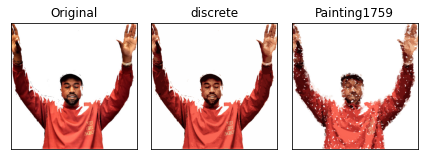

Wall time: 22min 35s


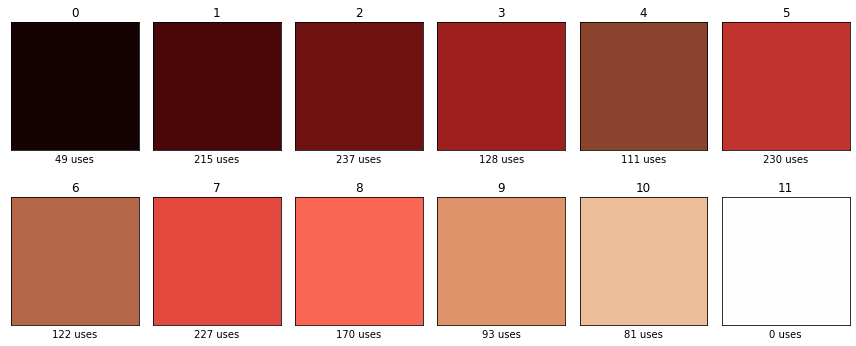

In [313]:
%%time

img = cv2.imread('../../HumanoidPainter/image/ye.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('../../HumanoidPainter/image/vangogh.png', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('images/tomato.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('../../HumanoidPainter/image/hambone.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('Coolin_AnimationSequence/Assignment30016.png', cv2.IMREAD_UNCHANGED)
# if img.shape[2] == 4:
#     trans_mask = img[:,:,3] == 0
#     img[trans_mask] = [255, 255, 255, 255]
#     img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
# img = cv2.resize(img, (500,500))
# img = img[:,:,::-1]
img = cv2.resize(img, (500,500))

fig, ax = plt.subplots(1,3)
ax[0].imshow(cv2.resize(img, (500,500)))
ax[0].title.set_text('Original')

allowed_colors = color_cluster(img[:,:,::-1], n_colors=12)
# So when running it a few times, similar results
allowed_colors = sorted(allowed_colors, key=lambda l:np.mean(l), reverse=False)

img = discretize_image(img[:,:,::-1], allowed_colors)
# img[np.mean(img, axis=2) > 100, :] = 255
ax[1].imshow(cv2.resize(img, (500,500)))
ax[1].title.set_text('discrete')

painting, s = paint(img, [6], T=[2000], curved=False)

ax[2].imshow(cv2.resize(painting.cpu().numpy(), (500,500)))
ax[2].title.set_text('Painting' + str(len(s)))

[a.set_yticks([]) + a.set_xticks([]) for a in ax]
plt.tight_layout()
plt.show()
save_strokes_for_robot(s, img, painting.cpu().numpy(), allowed_colors, ignore_whites=True, output_dir='nathan')

0


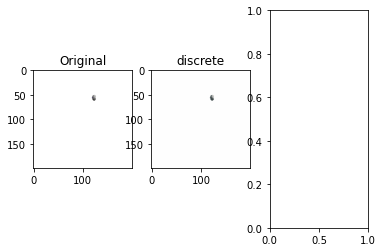

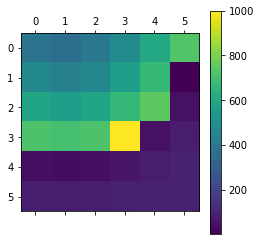

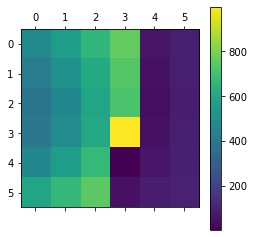

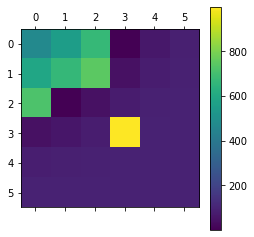

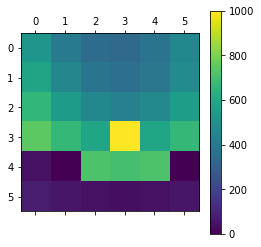

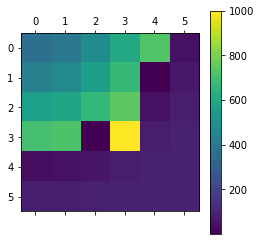

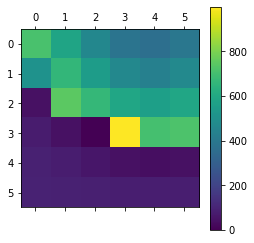

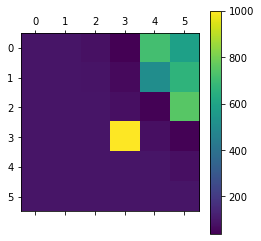

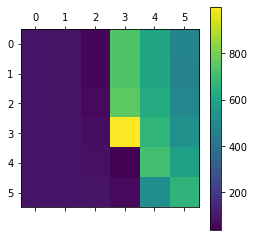

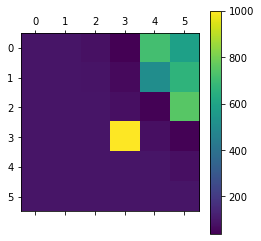

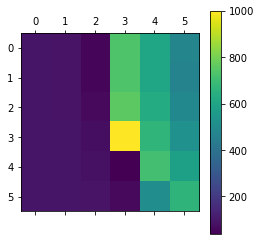

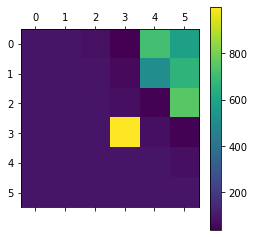

KeyboardInterrupt: 

In [292]:
%%time
if not os.path.exists('coolin_paint_instructions'):
    os.mkdir('coolin_paint_instructions')
i = 0


img = cv2.imread('Coolin_AnimationSequence/Assignment30016.png', cv2.IMREAD_UNCHANGED)[80:-80,450:-150,:]#[:,:,::-1]
if img.shape[2] == 4:
    trans_mask = img[:,:,3] == 0
    img[trans_mask] = [255, 255, 255, 255]
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
img = cv2.resize(img, (500,500))
img = img[:,:,::-1]
allowed_colors = color_cluster(img[:,:,::-1], n_colors=6)
# So when running it a few times, similar results
allowed_colors = sorted(allowed_colors, key=lambda l:np.mean(l), reverse=False)
    
for fn in os.listdir('Coolin_AnimationSequence'):
    print(i)
    img = cv2.imread('Coolin_AnimationSequence/' + fn, cv2.IMREAD_UNCHANGED)[80:-80,450:-150,:]#[:,:,::-1]
    
    if img.shape[2] == 4:
        trans_mask = img[:,:,3] == 0
        img[trans_mask] = [255, 255, 255, 255]
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.resize(img, (200,200))
    img = img[:,:,::-1]
    
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(img)
    ax[0].title.set_text('Original')

    img = discretize_image(img[:,:,::-1], allowed_colors)

    ax[1].imshow(img)
    ax[1].title.set_text('discrete')

    painting, s = paint(img, [6], T=[800], curved=False)

    ax[2].imshow(painting.cpu())
    ax[2].title.set_text('Painting' + str(len(s)))

    [a.set_yticks([]) + a.set_xticks([]) for a in ax]
    plt.tight_layout()
    plt.show()
    save_strokes_for_robot(s, img, painting.cpu().numpy(), allowed_colors, ignore_whites=True, output_dir='coolin_paint_instructions/'+str(i))
    i += 1

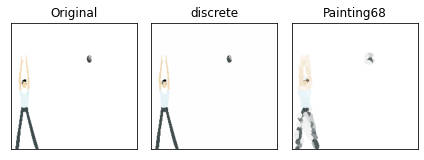

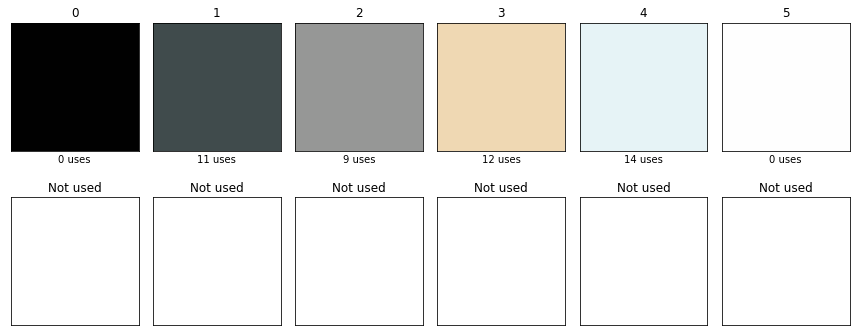

In [114]:
img = cv2.imread('Coolin_AnimationSequence/Assignment30016.png', cv2.IMREAD_UNCHANGED)[80:-80,450:-150,:]#[:,:,::-1]
if img.shape[2] == 4:
    trans_mask = img[:,:,3] == 0
    img[trans_mask] = [255, 255, 255, 255]
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
img = cv2.resize(img, (500,500))
img = img[:,:,::-1]
allowed_colors = color_cluster(img[:,:,::-1], n_colors=6)
# So when running it a few times, similar results
allowed_colors = sorted(allowed_colors, key=lambda l:np.mean(l), reverse=False)

img = cv2.imread('Coolin_AnimationSequence/Assignment30081.png', cv2.IMREAD_UNCHANGED)[80:-80,450:-150,:]
if img.shape[2] == 4:
    trans_mask = img[:,:,3] == 0
    img[trans_mask] = [255, 255, 255, 255]
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
img = cv2.resize(img, (200,200))
img = img[:,:,::-1]

fig, ax = plt.subplots(1,3)
ax[0].imshow(img)
ax[0].title.set_text('Original')

img = discretize_image(img[:,:,::-1], allowed_colors)

ax[1].imshow(img)
ax[1].title.set_text('discrete')

painting, s = paint(img, [6], T=[600], curved=False)

ax[2].imshow(painting.cpu())
ax[2].title.set_text('Painting' + str(len(s)))

[a.set_yticks([]) + a.set_xticks([]) for a in ax]
plt.tight_layout()
plt.show()
save_strokes_for_robot(s, img, painting.cpu().numpy(), allowed_colors, ignore_whites=True, output_dir='81')

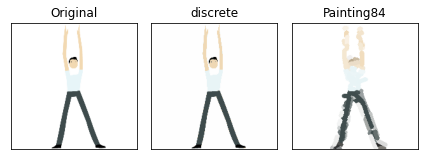

Wall time: 14 s


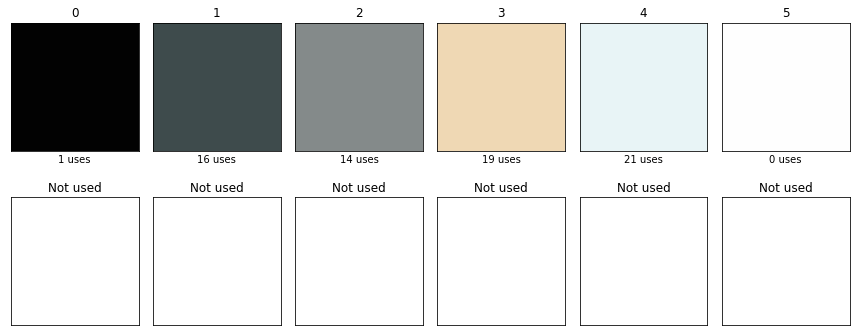

In [234]:
%%time

img = cv2.imread('frame0.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
img = cv2.imread('../../HumanoidPainter/image/vangogh.png', cv2.IMREAD_COLOR)[:,:,::-1]
img = cv2.imread('../../HumanoidPainter/image/coolin_ani.png', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('nathan.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
img = cv2.resize(img, (200,200))

fig, ax = plt.subplots(1,3)
ax[0].imshow(img)
ax[0].title.set_text('Original')

allowed_colors = color_cluster(img[:,:,::-1], n_colors=6)
# So when running it a few times, similar results
allowed_colors = sorted(allowed_colors, key=lambda l:np.mean(l), reverse=False)

img = discretize_image(img[:,:,::-1], allowed_colors)
# img[np.mean(img, axis=2) > 100, :] = 255
ax[1].imshow(img)
ax[1].title.set_text('discrete')

painting, s = paint(img, [6], T=[150], curved=False)

ax[2].imshow(painting.cpu())
ax[2].title.set_text('Painting' + str(len(s)))

[a.set_yticks([]) + a.set_xticks([]) for a in ax]
plt.tight_layout()
plt.show()
save_strokes_for_robot(s, img, painting.cpu().numpy(), allowed_colors, ignore_whites=True, output_dir='nathan')

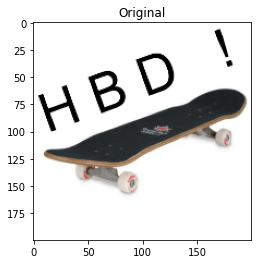

KeyboardInterrupt: 

In [516]:
%%time
np.random.seed(0)
img = cv2.imread('../../HumanoidPainter/image/rabbit2.png', cv2.IMREAD_COLOR)[:,:,::-1]
img = cv2.imread('../../HumanoidPainter/image/hambone.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('../../HumanoidPainter/image/hambone_stylized.png', cv2.IMREAD_COLOR)[:,:,::-1]
img = cv2.imread('../../HumanoidPainter/image/alex_katz.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('../../HumanoidPainter/image/circle.png', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('../../HumanoidPainter/image/colin_bike.png', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('../../HumanoidPainter/image/stick.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
img = cv2.imread('skate.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
# img = cv2.imread('BDAY.jpg', cv2.IMREAD_COLOR)[:,:,::-1]
img = cv2.imread('hbd2.png', cv2.IMREAD_COLOR)[:,:,::-1]
img = cv2.resize(img, (200,200))
plt.imshow(img)
plt.title('Original')
plt.show()

allowed_colors = color_cluster(img[:,:,::-1], n_colors=6)
# So when running it a few times, similar results
allowed_colors = sorted(allowed_colors,key=lambda l:np.mean(l), reverse=False)

# img = discretize_image(img[:,:,::-1], allowed_colors)
#img = cv2.medianBlur(img, ksize=13)
# plt.imshow(img.astype(np.uint8))
# plt.title('Discretized')
# plt.show()

painting, s = paint(img, [6], T=[400], curved=False)
# painting, s = paint(img, [6], T=[100], curved=False)
#painting, s = paint(img, [8,4, 2], T=200, curved=True, f_g=1)

plt.imshow(painting)
plt.title('Painting')
plt.show()
print(len(s))
# save_strokes_for_robot(s, img, painting, 5, allowed_colors, ignore_whites=True)

In [216]:
int(0.999)

0

(2, 2)
[[100 200]
 [255  50]]
5.58 µs ± 450 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


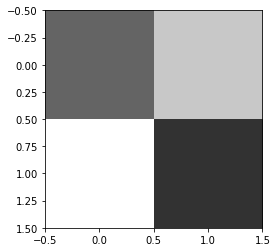

torch.Size([2, 2, 3])
tensor([[[100, 100, 100],
         [200, 200, 200]],

        [[255, 255, 255],
         [ 50,  50,  50]]], dtype=torch.int32)

torch.Size([2, 2])
tensor([[100, 200],
        [255,  50]], dtype=torch.int32)
17.4 µs ± 255 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
torch.Size([2, 2, 3])
tensor([[[100, 100, 100],
         [200, 200, 200]],

        [[255, 255, 255],
         [ 50,  50,  50]]], dtype=torch.int32)


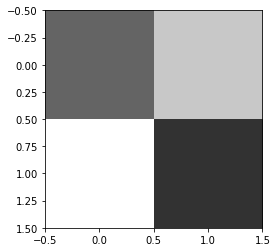

In [31]:
a = np.array([[100,200],[255,50]])
print(a.shape, a, sep='\n')
%timeit tile = np.tile(a[:,:, np.newaxis], (1,1,3))
plt.imshow(tile)
plt.show()
print(tile.shape, tile, sep='\n')
print()
a = torch.from_numpy(a).to(device)
print(a.shape, a, sep='\n')
# tile = torch.cat(3*[a]).view((2,2,3))
# tile = a.unsqueeze(1).repeat(1,4,1).view(-1,3)
# tile = a.unsqueeze(0).transpose(0,1).repeat(1,3,1)#.view(-1,3)
%timeit tile = a.unsqueeze(2).repeat(1,1,3)#.view(-1,3)
print(tile.shape, tile, sep='\n')
plt.imshow(tile)
plt.show()

In [ ]:
# THESE ARE SO SLOW

x_inds_torch, y_inds_torch = None, None
def draw_spline_stroke_torch(K, r, width=128, height=128):
    canvas = torch.zeros([width, height], dtype=torch.bool, device=device)
    
#     global x_inds_torch, y_inds_torch
#     x_inds_torch = torch.arange(0, width, device=device).unsqueeze(0) if x_inds_torch is None else x_inds_torch
#     y_inds_torch = torch.arange(0, height, device=device).unsqueeze(1) if y_inds_torch is None else y_inds_torch

    
#     z = max(int(r / 1.65), 1)
#     for f in K:
#         x = f[1]
#         y = f[0] # pretty confusing why these are backwards
#         # The two lines below could be merged, but I stored the mask
#         # for code clarity.
#         mask = (x_inds_torch-x)**2 + (y_inds_torch-y)**2 < z**2
#         canvas = canvas | mask
#         #canvas[(x_inds_torch-x)**2 + (y_inds_torch-y)**2 < z**2] = 1
    
    return 1 - canvas.float()#torch.from_numpy(1 - canvas).to(device)  #cv2.resize(canvas, dsize=(height, width))

x_inds_np, y_inds_np = None, None
def draw_spline_stroke_numpy(K, r, width=128, height=128):
    canvas = np.zeros([width, height], dtype=bool)
    
#     global x_inds_np, y_inds_np
#     x_inds_np = np.arange(0, width)[np.newaxis,:] if x_inds_np is None else x_inds_np
#     y_inds_np = np.arange(0, height)[:,np.newaxis] if y_inds_np is None else y_inds_np

#     z = max(int(r / 1.65), 1)
#     for f in K:
#         x = f[1]
#         y = f[0] # pretty confusing why these are backwards
#         # The two lines below could be merged, but I stored the mask
#         # for code clarity. https://stackoverflow.com/questions/49330080/numpy-2d-array-selecting-indices-in-a-circle
#         mask = (x_inds_np-x)**2 + (y_inds_np-y)**2 < z**2
#         canvas = np.logical_or(canvas, mask)
#         #canvas[(x_inds_np-x)**2 + (y_inds_np-y)**2 < z**2] = 1
    return torch.from_numpy(1 - canvas.astype(np.float32)).to(device)  #cv2.resize(canvas, dsize=(height, width))